<a href="https://colab.research.google.com/github/sanjayssj5/Data-Science/blob/main/NLP_03_Interacting_with_Document_Search_Engines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Search engines

This notebook shows how to use [PyTerrier](https://github.com/terrier-org/pyterrier) on the [CORD19 corpus](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7251955/) and the [TREC Covid test collection](https://ir.nist.gov/covidSubmit/).
Hereafter we are going to see how to:
- index a collection
- access an index
- search an index
- compare the performances of indexing approaches
- learn ranking
- evaluate ranking

The notebook in mainly based on the tutorials at this [link](https://github.com/terrier-org/cikm2021tutorial/tree/main/notebooks), which are part of the tutorial series "[IR From Bag-of-words to BERT and Beyond through Practical Experiments](https://github.com/terrier-org/cikm2021tutorial/)" created for the [CIKM 2021](https://www.cikm2021.org/).

## Tools installation and configuration

PyTerrier is a Python framework, but uses the underlying [Terrier information retrieval toolkit](http://terrier.org) for many indexing and retrieval operations. While PyTerrier was new in 2020, Terrier is written in Java and has a long history dating back to 2001. PyTerrier makes it easy to perform IR experiments in Python, but using the mature Terrier platform for the expensive indexing and retrieval operations. 

PyTerrier is installed as follows. This might take a few minutes, in the meanwhile you can take a look at [PyTerrier documentation](https://pyterrier.readthedocs.io/en/latest/).

In [1]:
!pip install -q python-terrier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 KB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 KB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 KB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.2/287.2 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 KB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

The next step is to initialise PyTerrier. This is performed using PyTerrier's `init()` method. The `init()` method is needed as PyTerrier must download Terrier's jar file and start the Java virtual machine. We prevent `init()` from being called more than once by checking `started()`.

In [2]:
import pyterrier as pt
if not pt.started():
  pt.init()

terrier-assemblies 5.7 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.7 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.9.2 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7



## Introduction to document indexing and searching

Much of PyTerrier's view of the world is wrapped up in Pandas dataframes. Let's consider some textual documents in a dataframe.

We can start importing Pandas, a well known Python library to manage tabular data. 
You can find Pandas' documentation at the following [link](https://pandas.pydata.org).


In [3]:
import pandas as pd

We can set the length of the displayed output to avoid truncating too much text

In [4]:
pd.set_option('display.max_colwidth', 150)

### Documents

Finally we can create some sample documents to store in a `DataFrame

In [5]:
docs_df = pd.DataFrame(
    [
        ["d1", "This is the first article in my collection of articles."],
        ["d2", "This is another article in my collection."],
        ["d3", "The topic of this third article is unknown."]
    ], 
    columns=["docno", "text"]
)
docs_df

,docno,text
0,d1,This is the first article in my collection of articles.
1,d2,This is another article in my collection.
2,d3,The topic of this third article is unknown.


### Indexing

Before any search engine can estimate which documents are most likely to be relevant for a given query, it must index the documents. 

In the following cell, we index the dataframe's documents. The index, with all its data structures, is written into a directory that we will call `index_3docs`. You can see it in the Google colab files folder on the left.

In [6]:
indexer = pt.DFIndexer("./index_3docs", overwrite=True)
index_ref = indexer.index(docs_df["text"], docs_df["docno"])
index_ref.toString()

'./index_3docs/data.properties'

`IndexRef` provides the location where the index is stored. Indeed, we can look in the `index_3docs` directory and see that it has created various files: 

In [7]:
!ls -lh index_3docs/

total 44K
-rw-r--r-- 1 root root    4 Mar 15 11:43 data.direct.bf
-rw-r--r-- 1 root root   51 Mar 15 11:43 data.document.fsarrayfile
-rw-r--r-- 1 root root    5 Mar 15 11:43 data.inverted.bf
-rw-r--r-- 1 root root  516 Mar 15 11:43 data.lexicon.fsomapfile
-rw-r--r-- 1 root root  273 Mar 15 11:43 data.lexicon.fsomaphash
-rw-r--r-- 1 root root   24 Mar 15 11:43 data.lexicon.fsomapid
-rw-r--r-- 1 root root   33 Mar 15 11:43 data.meta-0.fsomapfile
-rw-r--r-- 1 root root   24 Mar 15 11:43 data.meta.idx
-rw-r--r-- 1 root root   48 Mar 15 11:43 data.meta.zdata
-rw-r--r-- 1 root root 4.1K Mar 15 11:43 data.properties


We can now load the index:

In [8]:
index = pt.IndexFactory.of(index_ref)

This is a Terrier index structure, which provides methods such as:
 - `getCollectionStatistics()`
 - `getInvertedIndex()`
 - `getLexicon()`

Note Terrier is written in Java. (Yes, yes... I know... Java... 🤢) 
The Javadoc documentation is here: 
http://terrier.org/docs/current/javadoc/org/terrier/structures/Index.html

Let's see what is returned by the `CollectionStatistics()` method:

In [9]:
print(index.getCollectionStatistics().toString())

Number of documents: 3
Number of terms: 6
Number of postings: 9
Number of fields: 0
Number of tokens: 10
Field names: []
Positions:   false



Ok, that seems fair – we have 3 documents. But why only 6 terms? 
Let's check the [`Lexicon`](http://terrier.org/docs/current/javadoc/org/terrier/structures/Lexicon.html), which is our vocabulary. The `Lexicon` contains a set of terms, so we need to iterate over it:

In [10]:
for kv in index.getLexicon():
    print(kv.getKey(),": ", kv.getValue().toString())

articl :  term1 Nt=3 TF=4 maxTF=2 @{0 0 0}
collect :  term0 Nt=2 TF=2 maxTF=1 @{0 0 7}
first :  term2 Nt=1 TF=1 maxTF=1 @{0 1 3}
third :  term4 Nt=1 TF=1 maxTF=1 @{0 1 5}
topic :  term3 Nt=1 TF=1 maxTF=1 @{0 2 1}
unknown :  term5 Nt=1 TF=1 maxTF=1 @{0 2 5}


We see the terms and the statistics collected about each.
Note that stopwords were removed and Porter's stemmer has been applied.
Here:
 - `Nt` is the number of unique documents that each term occurs in – this is useful for calculating IDF.
 - `TF` is the total number of occurrences of term in corpus.

Finally, we can use the square bracket notation to lookup terms in the lexicon:


In [11]:
index.getLexicon()["articl"].toString()

'term1 Nt=3 TF=4 maxTF=2 @{0 0 0}'

And we can see how many times this term is used in each document that it occurs in (by iterating over the posting lists):

In [12]:
pointer = index.getLexicon()["articl"]
for posting in index.getInvertedIndex().getPostings(pointer):
    print(f'{posting.toString()} doclen = {posting.getDocumentLength()}')

ID(0) TF(2) doclen = 4
ID(1) TF(1) doclen = 2
ID(2) TF(1) doclen = 4


We can see that `"article"` occurs in each of the three documents. 

### Searching an Index

Now that we have indexed our documents, we can run a search over the document collection:

In [13]:
query = "articles"

br = pt.BatchRetrieve(index, wmodel="TF_IDF")
br.search(query)

,qid,docid,docno,rank,score,query
0,1,0,d1,0,0.710059,articles
1,1,1,d2,1,0.652174,articles
2,1,2,d3,2,0.504202,articles


Here we used the TF-IDF weighting formula to rank the results. 

The `search()` method returns a dataframe with columns:
 - `qid`: the query identifier
 - `docid`: integer identifier for document 
 - `docno`: string identifier for document
 - `rank`: rank position
 - `score`: tf-idf score
 - `query`: the input query

### Multiple searches

We can also run multiple queries at once:

In [14]:
queries = pd.DataFrame([["query1", "articles"], ["query2", "first article"], ["query3", "unknown"]], columns=["qid", "query"])
br(queries)

,qid,docid,docno,rank,score,query
0,query1,0,d1,0,0.710059,articles
1,query1,1,d2,1,0.652174,articles
2,query1,2,d3,2,0.504202,articles
3,query2,0,d1,0,1.718463,first article
4,query2,1,d2,1,0.652174,first article
5,query2,2,d3,2,0.504202,first article
6,query3,2,d3,0,1.008403,unknown


## Loading a proper dataset

We'll now load a real dataset of COVID-19 related scientific articles (called CORD19) that is available as an example in PyTerrier

In [15]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')

We just downloaded the data. Now we index and save the dataset.

The CORD19 corpus contains articles about the COVID-19, we are going to retrieve only the abstract of these articles to compose our documents. The indexing will take a while to run since there are almost 200,000 articles. 

In [16]:
pt_index_path = './terrier_cord19'
indexer = pt.index.IterDictIndexer(pt_index_path, meta_reverse=[])
index_ref = indexer.index(cord19.get_corpus_iter(), fields=('abstract',), meta=('docno',))

[INFO] [starting] building docstore
[INFO] If you have a local copy of https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/80d664e496b8b7e50a39c6f6bb92e0ef
[INFO] [starting] https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv
docs_iter:   0%|                                    | 0/192509 [00:00<?, ?doc/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 0.00/269M [00:00<?, ?B/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.0%| 57.3k/269M [00:00<08:07, 552kB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.1%| 262k/269M [00:00<03:46, 1.19MB/s]
https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/2020-07-16/metadata.csv: 0.4%| 1.16M/269M [00:00<01:18, 3.42MB/s]
https://ai2-semanticscholar-cord-

cord19/trec-covid documents:   0%|          | 0/192509 [00:00<?, ?it/s]

<ipython-input-16-8a5de147abf6>:3: DeprecationWarning: specifying meta and meta_lengths in IterDictIndexer.index() is deprecated, use constructor instead
  index_ref = indexer.index(cord19.get_corpus_iter(), fields=('abstract',), meta=('docno',))


11:56:30.266 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (6iu1dtyl) - further warnings are suppressed
11:58:12.667 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer - Indexed 54937 empty documents


Now load the index and print statistics:

In [17]:
index = pt.IndexFactory.of(index_ref)
print(index.getCollectionStatistics().toString())

Number of documents: 192509
Number of terms: 151235
Number of postings: 11554033
Number of fields: 1
Number of tokens: 17728468
Field names: [abstract]
Positions:   false



Let's run a query:

In [18]:
query = "chemical reactions"

tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")
tfidf.search(query)

,qid,docid,docno,rank,score,query
0,1,18717,iavwkdpr,0,11.035982,chemical reactions
1,1,171636,v3blnh02,1,10.329726,chemical reactions
2,1,147193,ei4rb8fr,2,10.317138,chemical reactions
3,1,121217,msdycum2,3,9.653734,chemical reactions
4,1,170863,sj8i9ss2,4,9.500211,chemical reactions
...,...,...,...,...,...,...
995,1,2428,38aabxh1,995,3.790183,chemical reactions
996,1,14752,u709r8ss,996,3.790183,chemical reactions
997,1,20074,wxi1xsbo,997,3.790183,chemical reactions
998,1,117156,ts3obwts,998,3.790183,chemical reactions


### Evaluating the results

So far, we have been creating search engine models, but we haven't decided if any of them are actually any good.

The CORD19 dataset also contains set of queries and relevance assessments (aka qrels). For historical reasons, the queries are called "topics". Let's have a look at the first 5:

In [19]:
cord19.get_topics(variant='title').head(5)

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [6.57MB/s]


,qid,query
0,1,coronavirus origin
1,2,coronavirus response to weather changes
2,3,coronavirus immunity
3,4,how do people die from the coronavirus
4,5,animal models of covid 19


And the first 5 relevance judgements (called qrels):

In [20]:
cord19.get_qrels().head(5)

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt: [00:00] [1.14MB] [6.74MB/s]


,qid,docno,label,iteration
0,1,005b2j4b,2,4.5
1,1,00fmeepz,1,4
2,1,010vptx3,2,0.5
3,1,0194oljo,1,2.5
4,1,021q9884,1,4


Now let us use these queries and relevance judgements to compare different retrieval functions to see how well they perform at ranking documents in the collection. 

To do this, we first need to get all of the qrels:

In [21]:
qrels = cord19.get_qrels()
qrels

,qid,docno,label,iteration
0,1,005b2j4b,2,4.5
1,1,00fmeepz,1,4
2,1,010vptx3,2,0.5
3,1,0194oljo,1,2.5
4,1,021q9884,1,4
...,...,...,...,...
69313,50,zvop8bxh,2,5
69314,50,zwf26o63,1,5
69315,50,zwsvlnwe,0,5
69316,50,zxr01yln,1,5


What values can the qrels take?

In [22]:
qrels['label'].unique()

array([ 2,  1,  0, -1])

Now we can use the TF-IDF model to rank the responses to the queries in the data set

In [23]:
results = tfidf(cord19.get_topics(variant='title').head(1))
results

,qid,docid,docno,rank,score,query
0,1,175892,zy8qjaai,0,7.080599,coronavirus origin
1,1,82224,8ccl9aui,1,6.775667,coronavirus origin
2,1,135326,ne5r4d4b,2,6.683114,coronavirus origin
3,1,122804,75773gwg,3,6.590340,coronavirus origin
4,1,122805,kn2z7lho,4,6.590340,coronavirus origin
...,...,...,...,...,...,...
995,1,180809,0y0hau9l,995,4.214228,coronavirus origin
996,1,148967,f8vbflx6,996,4.212887,coronavirus origin
997,1,183189,uadfehr6,997,4.210201,coronavirus origin
998,1,67321,n5hnx2c3,998,4.202319,coronavirus origin


Let's give a look to how the predicted score and the target label compare

In [24]:
results.merge(qrels, on=["qid", "docno"], how="left").fillna(0)

,qid,docid,docno,rank,score,query,label,iteration
0,1,175892,zy8qjaai,0,7.080599,coronavirus origin,1.0,1
1,1,82224,8ccl9aui,1,6.775667,coronavirus origin,2.0,1
2,1,135326,ne5r4d4b,2,6.683114,coronavirus origin,0.0,1.5
3,1,122804,75773gwg,3,6.590340,coronavirus origin,2.0,5
4,1,122805,kn2z7lho,4,6.590340,coronavirus origin,2.0,3
...,...,...,...,...,...,...,...,...
995,1,180809,0y0hau9l,995,4.214228,coronavirus origin,0.0,0
996,1,148967,f8vbflx6,996,4.212887,coronavirus origin,0.0,0
997,1,183189,uadfehr6,997,4.210201,coronavirus origin,2.0,1.5
998,1,67321,n5hnx2c3,998,4.202319,coronavirus origin,0.0,0


Ok we can not tell a lot from here.

What we can do is use the PyTerrier evaluation interface to score our ranking system:

In [25]:
from pyterrier.measures import *

pt.Experiment(
    [tfidf],
    cord19.get_topics(variant='title'),
    cord19.get_qrels(),
    eval_metrics=["map", "ndcg", nDCG@10]
)

,name,map,ndcg,nDCG@10
0,BR(TF_IDF),0.180002,0.370767,0.583578


### BM25 Weighting Model

In the rest of this tutorial, we will be using a different index from the [Terrier Data Repository](http://data.terrier.org/). The new index contains information from entire documents (not just the abstract) and thus would take longer to create so we will use a ready-made one.

You will see progress bars while the files are downloading. 

In [26]:
bm25 = pt.BatchRetrieve.from_dataset(
    'trec-covid', 
    'terrier_stemmed', 
    wmodel='BM25'
)

data.lexicon.fsomapfile:   0%|          | 0.00/14.2M [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/4.38M [00:00<?, ?iB/s]

data.direct.bf:   0%|          | 0.00/23.2M [00:00<?, ?iB/s]

md5sums:   0%|          | 0.00/537 [00:00<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/4.56M [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/4.33k [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/21.3M [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/1.46M [00:00<?, ?iB/s]

data.meta-0.fsomapfile:   0%|          | 0.00/5.29M [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/0.99k [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/619k [00:00<?, ?iB/s]

Lets see how BM25 compares to TF_IDF in terms of two common ranking evaluation measures (MAP and NDCG)? The higher values the better.  

In [31]:
# TODO
pt.Experiment(
    [tfidf, bm25],
    cord19.get_topics(variant='title'),
    cord19.get_qrels(),
    eval_metrics=["map", "ndcg"]
)

,name,map,ndcg
0,BR(TF_IDF),0.180002,0.370767
1,BR(BM25),0.207913,0.411424


## Additional tools installation and configuration

We install the [LightGBM](https://lightgbm.readthedocs.io/en/latest/) and [FastRank](https://github.com/jjfiv/fastrank) learning-to-rank implementations.

In [33]:
!pip install -q --upgrade fastrank lightgbm==3.1.1

## Transformations and pipelines

For this part of the notebook, we'll be using a Terrier index with term position information. We could create a new index adding the `blocks=True` kwarg:
```python
pt_index_path = './terrier_cord19_blocks'
indexer = pt.index.IterDictIndexer(pt_index_path blocks=True)
index_ref = indexer.index(cord19.get_corpus_iter(), fields=('abstract',), meta=('docno',))
```

However, its just as quick to use the pre-built index from the Terrier Data Repository. We use the ['terrier_stemmed_positions'](http://data.terrier.org/trec-covid.dataset.html#terrier_stemmed_positions) index variant.

In [34]:
index = pt.IndexFactory.of(
    pt.get_dataset('trec-covid').get_index('terrier_stemmed_positions')
)

data.lexicon.fsomapfile:   0%|          | 0.00/14.2M [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/4.38M [00:00<?, ?iB/s]

data.direct.bf:   0%|          | 0.00/50.6M [00:00<?, ?iB/s]

md5sums:   0%|          | 0.00/537 [00:00<?, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/4.56M [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/4.37k [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/48.7M [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/1.46M [00:00<?, ?iB/s]

data.meta-0.fsomapfile:   0%|          | 0.00/5.29M [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/0.99k [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/619k [00:00<?, ?iB/s]

#### Transformers and operators

You'll have noted that BatchRetrieve has a `transform()` method that takes as input a dataframe, and returns another dataframe, which is somehow a *transformation* of the earlier dataframe (e.g., a retrieval transformation). In fact, `BatchRetrieve` is just one of many similar objects in PyTerrier, which we call [transformers](https://pyterrier.readthedocs.io/en/latest/transformer.html) (represented by the `TransformerBase` class).

Let's give a look at a `BatchRetrieve` transformer, starting with one for the TF_IDF weighting model.

In [35]:
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")

TF-IDf is an example of PyTerrier transformer

In [39]:
print(isinstance(tfidf, pt.transformer.Transformer))

True


If you're interested, this prints the type hierarchy of the TF_IDF class

In [40]:
tfidf.__class__.__mro__

(pyterrier.batchretrieve.BatchRetrieve,
 pyterrier.batchretrieve.BatchRetrieveBase,
 pyterrier.transformer.Transformer,
 matchpy.expressions.expressions.Symbol,
 matchpy.expressions.expressions.Atom,
 matchpy.expressions.expressions.Expression,
 object)

#### Pipeline Construction

The interesting capability of all transformers is that they can be combined using Python operators (through a process called *operator overloading*).

Concretely, imagine that you want to chain transformers together – e.g. rank documents first by Tf then re-ranked the *exact same* documents by TF_IDF. We can do this using the `>>` operator – we call this *composition*, or "*then*".

In [38]:
tf = pt.BatchRetrieve(index, wmodel="Tf")

tf(cord19.get_topics(variant='title').head(1))

,qid,docid,docno,rank,score,query
0,1,146463,jkrj0lbm,0,25.0,coronavirus origin
1,1,25564,jlzncyax,1,19.0,coronavirus origin
2,1,45520,8l411r1w,2,18.0,coronavirus origin
3,1,29357,gnxbfcod,3,15.0,coronavirus origin
4,1,63454,cpc6v40g,4,15.0,coronavirus origin
...,...,...,...,...,...,...
995,1,89330,g0uxidjd,995,5.0,coronavirus origin
996,1,90134,0g7kswz7,996,5.0,coronavirus origin
997,1,90326,m1evoj5p,997,5.0,coronavirus origin
998,1,90327,jcimpmhm,998,5.0,coronavirus origin


Now let's define a pipeline 

In [41]:
pipeline = tf >> tfidf
print(isinstance(tfidf, pt.transformer.TransformerBase))

pipeline( cord19.get_topics(variant='title').head(1) )

False


,qid,docid,docno,rank,score,query
0,1,122553,75773gwg,0,6.962882,coronavirus origin
1,1,122554,kn2z7lho,1,6.962882,coronavirus origin
2,1,122555,4fb291hq,2,6.962882,coronavirus origin
3,1,135022,ne5r4d4b,3,6.962882,coronavirus origin
4,1,186652,hl967ekh,4,6.962882,coronavirus origin
...,...,...,...,...,...,...
995,1,146064,oshov14d,995,1.659938,coronavirus origin
996,1,32458,xtfjw1ag,996,1.658102,coronavirus origin
997,1,144831,vr7vm64u,997,1.633192,coronavirus origin
998,1,69522,nwpzla09,998,1.589357,coronavirus origin


There are a number of PyTerrier operators – there are more examples in the [PyTerrier documentation on operators](https://pyterrier.readthedocs.io/en/latest/operators.html)

Now we can create a ranker that performs the following:
 - obtains the top 10 highest scoring documents by term frequency (`wmodel="Tf"`)
 - obtains the top 10 highest scoring documents by TF.IDF (`wmodel="TF_IDF"`)
 - reranks only those documents found in EITHER of the previous retrieval settings using BM25.

by making use of PyTerrier operators combining different BatchRetrieve instances.

How many documents are retrieved by this full pipeline for the query `"chemical"`.
> If you obtain the correct solution, the document with docno `"8hykq71k"` should have a score of $12.646089$ for query `"chemical"`.

Hints:
 - choose careully your [PyTerrier operators](https://pyterrier.readthedocs.io/en/latest/operators.html)
 - you should not need to perform any Pandas dataframe operations

In [42]:
# TODO
pipe = ((tf % 10) | (tfidf % 10)) >> pt.BatchRetrieve(index, wmodel='BM25')
pipe.search('chemical')

,qid,docid,docno,rank,score,query
0,1,15671,8hykq71k,0,12.646089,chemical
1,1,37756,jn5qi1jb,1,12.595498,chemical
2,1,87397,ck6clsty,2,12.425298,chemical
3,1,134017,0smev8vt,3,12.414508,chemical
4,1,18717,iavwkdpr,4,12.221431,chemical
5,1,141688,77c9ohxj,5,12.153431,chemical
6,1,182167,65e8ol64,6,11.913434,chemical
7,1,26941,vcsq0630,7,11.892193,chemical
8,1,11310,3ehh7wme,8,11.891254,chemical
9,1,56573,sps45fj5,9,11.872442,chemical


#### Other transformers in the toolbox

Lets start creating more interesting retrieval pipelines. We'll define these, but firstly lets recap on the PyTerrier datamodel:
 - $Q$: a set of queries
 - $D$: a set of documents
 - $R$: a set of retrieved documents for a set of queries

Lets use three: 
 - `pt.BatchRetrieve(index, wmodel="BM25")` - input $Q$ or $R$ (retrieval or reranking), output $R$
 - `pt.rewrite.SDM()` (sequential dependence proximity model) - input $Q$, output $Q$. 
 - `pt.rewrite.Bo1QueryExpansion(index)` - input $R$, output $Q$.




In [45]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
sdm = pt.rewrite.SDM()
qe = pt.rewrite.Bo1QueryExpansion(index)

Lets see how `sdm` applies to a given query. This generates a query in an Indri-like query language that Terrier (c.f. `pt.BatchRetrieve()`) can understand.
 - `#combine()` - is used for weighting sub-expressions
 - `#1() - matches as a phrase, i.e. how many times does the constituent words exactly match as a phrase
 - `#uw8()` and `#uw12()` look for how many times the constituent words appear in unordered windows of 8 or 12 tokens.
 - finally, the weighting model is overridden for these query terms.
  

In [46]:
sdm.search("chemical reactions").iloc[0]["query"]

'chemical reactions #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#1(chemical reactions)) #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#uw8(chemical reactions)) #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#uw12(chemical reactions))'

#### Experimenting with Pipelines

Conduct an [Experiment](https://pyterrier.readthedocs.io/en/latest/experiments.html) comparing sequential dependence model and Bo1 query expansion on TREC CORD19 with the BM25 baseline. You will need to construct appropriate pipelines, by considering the input and output datatypes of the `bm25`, `sdm` and `qe`. 

Which approaches result in significant increases in NDCG and MAP? Is NDCG@10 also improved?

In [47]:
topics = cord19.get_topics(variant='title')
qrels = cord19.get_qrels()

In [49]:
# TODO
pt.Experiment(
  # These are our 3 pipelines
  [bm25, bm25 >> qe >> bm25, sdm >> bm25],
  topics,
  qrels,
  eval_metrics=[MAP, nDCG, nDCG@10],
  # We declare BM25 as the baseline to obtain significance testing
  baseline=0,
  names=["BM25", "BM25 >> QE >> BM25", "SDM >> BM25"]
)

,name,AP,nDCG,nDCG@10,AP +,AP -,AP p-value,nDCG +,nDCG -,nDCG p-value,nDCG@10 +,nDCG@10 -,nDCG@10 p-value
0,BM25,0.207913,0.411424,0.603072,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 >> QE >> BM25,0.219510,0.430625,0.603828,36.0,14.0,0.007743,35.0,15.0,0.000148,26.0,19.0,0.958516
2,SDM >> BM25,0.209975,0.412734,0.603928,39.0,11.0,0.000241,37.0,13.0,0.007330,13.0,13.0,0.846987


## Learning to Rank

In this last part of the notebook, you will experience constructing, learning, evaluating and analysing learning to rank pipelines.


Firstly, lets split out topics into train, validation and test sets. TREC Covid only has 50 topics, which isnt a lot for training. We'll split this 30 for training 5 for validation and 15 for test. We will also examine statistical significance, even if this is artificial for 15 topics.

We're only going to-rank the top 10 documents for each query - hopefully learning to rank can help to re-rank the top 10 documents to be more effective.

We define some constants to controthe cutoff and make the experiments reproducible 

In [48]:
RANK_CUTOFF = 10
SEED = 42

Then we use the splitting utility from Scikit-Learn

In [50]:
from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(topics, test_size=15, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=5, random_state=SEED)

### Feature Set

Lets define our feature set.  We're going to have a total of 7 features:

1.   the BM25 abstract score;
2.   sequential dependence model, scored by BM25;
3.   does the abstract contain 'coronavirus covid', scored by BM25;
4.   the BM25 score on the title (even though we didnt index it earlier!);
5.   was the paper released/published in 2020? Recent papers were more useful for this task;
6.   does the paper have a DOI, i.e. is it a formal publication?
7.   the coordinate match score for the query - i.e. how many query terms appear in the abstract.

Several of these feature require additional metadata `["title", "date", "doi"]`. Fortunately, the TREC Covid dataset allows us to obtain more metadata after indexing. We use `pt.text.get_text(cord19, ["title", "date", "doi"])` to retrieve these extra metadata columns.


In [51]:
ltr_feats1 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(cord19, ["title", "date", "doi"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of text for query 'coronavirus covid'
    (pt.apply.query(lambda row: 'coronavirus covid') >> bm25)
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", takes='docs', wmodel='BM25') ) 
    ** # date 2020
    (pt.apply.doc_score(lambda row: int("2020" in row["date"])))
    ** # has doi
    (pt.apply.doc_score(lambda row: int( row["doi"] is not None and len(row["doi"]) > 0) ))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

For reference, lets record the feature names here too

In [52]:
fnames=["BM25", "SDM", 'coronavirus covid', 'title', "2020", "hasDoi", "CoordinateMatch"]

Lets see the output for a particular query. We can see that we now have extra document metadata columns `["title", "date", "doi"]`, as well as the all-important `"features"` columns. This makes dataframe have type $R_f$. Indeed,  it is this column that we use for learning.

In [53]:
ltr_feats1.search("coronovirus origin")

12:37:46.843 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,docid,docno,rank,score,query,title,date,doi,features
0,1,144734,6jvqsvy5,0,20.354386,coronovirus origin,What Have We Learned about Nursing from the Coronovirus Pandemic,2020-06-13,10.1016/j.jamda.2020.06.011,"[20.35438619404753, 20.35438619404753, 0.0, -0.7118298730388692, 1.0, 1.0, 1.0]"
1,1,13691,tkxfzhwh,1,19.958371,coronovirus origin,Astrocyte-derived TGF β is secreted during persistent coronovirus infection,2002-12-10,10.1016/0165-5728(94)90284-4,"[19.958371092978137, 19.958371092978137, 0.0, -0.6161156968832443, 0.0, 1.0, 1.0]"
2,1,54405,c67kgvr8,2,19.958371,coronovirus origin,"MERS coronovirus has probably been present in bats for many years, research shows.",2013,10.1136/bmj.f6141,"[19.958371092978137, 19.958371092978137, 0.0, -0.6161156968832443, 0.0, 1.0, 1.0]"
3,1,187070,8bn74f2z,3,19.329562,coronovirus origin,"Reply to Comments on 'Co‐infection of SARS‐CoV‐2 and HIV in a patient in Wuhan city, China’",2020-04-08,10.1002/jmv.25838,"[19.329562397928484, 19.329562397928484, 1.083461070258332, 0.0, 1.0, 1.0, 1.0]"
4,1,162708,3n9f84hg,4,18.973951,coronovirus origin,MP17-08 NEUROGENIC BLADDER DYSFUNCTION IN A MURINE MODEL OF MULTIPLE SCLEROSIS IS CAUSED BY CORONOVIRUS-INDUCED DEMYELINATION OF THE NERVOUS SYSTEM,2014-04-30,10.1016/j.juro.2014.02.529,"[18.973951486762303, 18.973951486762303, 0.0, -0.45350451588766666, 0.0, 1.0, 1.0]"
5,1,84009,0seoiqre,5,18.515491,coronovirus origin,Design and synthesis of dipeptidyl glutaminyl fluoromethyl ketones as potent severe acute respiratory syndrome coronovirus (SARS-CoV) inhibitors.,2006,,"[18.515490662809988, 18.515490662809988, 0.0, -0.45350451588766666, 0.0, 0.0, 1.0]"
6,1,92845,ciqs6l7e,6,17.666861,coronovirus origin,The spread of the COVID-19 coronavirus: Health agencies worldwide prepare for the seemingly inevitability of the COVID-19 coronavirus becoming end...,2020,,"[17.666860555114013, 17.666860555114013, 4.539235650941733, 0.0, 1.0, 0.0, 1.0]"
7,1,92846,qe9w4qbu,7,17.666861,coronovirus origin,The spread of the COVID-19 coronavirus: Health agencies worldwide prepare for the seemingly inevitability of the COVID-19 coronavirus becoming end...,2020,,"[17.666860555114013, 17.666860555114013, 4.539235650941733, 0.0, 1.0, 0.0, 1.0]"
8,1,151848,egzztatj,8,17.367750,coronovirus origin,The spread of the COVID‐19 coronavirus: Health agencies worldwide prepare for the seemingly inevitability of the COVID‐19 coronavirus becoming end...,2020-03-17,10.15252/embr.202050334,"[17.367750105171087, 17.367750105171087, 4.496088672217509, 0.0, 1.0, 1.0, 1.0]"
9,1,113996,a47onmje,9,17.077076,coronovirus origin,On the airborne aspect of COVID-19 coronovirus,2020-04-20,,"[17.07707581862232, 17.07707581862232, 1.2319544407039966, -0.6767835444975682, 1.0, 0.0, 1.0]"


We can also look at the raw features values (in this case for the first ranked document). Note that the BM25 in the "score" column above is also the first value in the feature array (20.54), because we used an identity transformer.

In [54]:
ltr_feats1.search("coronovirus origin").iloc[0]["features"]

12:37:49.581 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


array([20.35438619, 20.35438619,  0.        , -0.71182987,  1.        ,
        1.        ,  1.        ])

### Learning 

In this part of the notebook, we apply three different learning to rank techniques:

 - coordinate ascent from FastRank, a listwise linear technique
 - random forests from `scikit-learn`, a pointwise regression tree technique
 - LambdaMART from LightGBM, a listwise regression tree technique

In each case, we take our feature pipeline, `ltr_feats1`, and we compose it (`>>`) with the learned model. We use `pt.ltr.apply_learned_model()` which knows how to deal with different learners.

The full pipeline is then fitted (learned) using `.fit()`, specifying the training topics and qrels. Importantly, the preceeding stages of the pipeline (retrieval and feature calculation) are applied to the training topics in order to obtained the results, which are then passed to the learning to rank technique. LightGBM has early stopping enabled, which uses a validation topics set – similarly the validation topics are transformed into validation results.

Finally, `%time` is notebook "magic command" which displays how long learning takes for each technique. Learning for each technique takes < 30 seconds.

#### FastRank

In [55]:
import fastrank

train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe.fit(train_topics, cord19.get_qrels())

12:37:59.014 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
CPU times: user 9.3 s, sys: 127 ms, total: 9.43 s
Wall time: 7.71 s


#### Non-linear regression model

In [56]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(train_topics, cord19.get_qrels())

12:38:04.962 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.4s


CPU times: user 6.37 s, sys: 141 ms, total: 6.51 s
Wall time: 5.87 s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.8s finished


#### LambdaMART

In [57]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

%time lmart_x_pipe.fit(train_topics, cord19.get_qrels(), valid_topics, cord19.get_qrels())

12:38:12.623 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:38:13.978 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is s

/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.9/dist-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


### Evaluation

Lets now compare our ranking pipelines on our 15 topics with the BM25 baseline. In all cases, we're ranking only 10 results per query, so MAP will be lower. 

We'll report mean response time (`"mrt"`) as well as MAP, NDCG and NDCG@10 measures.

In [58]:
pt.Experiment(
    [bm25 % RANK_CUTOFF, ca_pipe, rf_pipe, lmart_x_pipe],
    test_topics,
    qrels, 
    names=["BM25",  "BM25 + CA(7f)", "BM25 + RF(7f)", "BM25 + LMart(7f)"],
    baseline=0,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt"]
)

12:38:17.330 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:38:19.757 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


12:38:22.569 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,map,ndcg,ndcg_cut_10,mrt,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,BM25,0.011515,0.044965,0.534369,47.205904,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 + CA(7f),0.012583,0.048822,0.571913,165.656942,6.0,5.0,0.118823,9.0,3.0,0.102075,9.0,3.0,0.115783
2,BM25 + RF(7f),0.013470,0.051125,0.594795,174.327438,9.0,2.0,0.013729,10.0,2.0,0.019839,10.0,2.0,0.015158
3,BM25 + LMart(7f),0.012251,0.047931,0.565957,180.932832,6.0,3.0,0.156135,9.0,4.0,0.050903,9.0,4.0,0.058490


Thats really interesting – all three learned models could improve NDCG@10 over BM25, but the coordinate ascent model improved the most (significantly so on all three metrics, but again on only 15 queries). Coordinate Ascent improved upto 10 queries.

### Analysis

Lets start to analyse our learned models. Two things we could do is either a feature ablation study, or to evaluate the performance of each feature independently. To to that, we compose the feature pipeline (`ltr_feats1`) with `pt.ltr.feature_to_score(i)` for some feature number $i$.

In [59]:
pt.Experiment(
    [ltr_feats1 >> pt.ltr.feature_to_score(i) for i in range(len(fnames))],
    test_topics,
    qrels, 
    names=fnames,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "num_rel_ret"]
)

12:38:25.991 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:38:28.411 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:38:30.973 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:38:33.474 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

,name,map,ndcg,ndcg_cut_10,num_rel_ret
0,BM25,0.011515,0.044965,0.534369,97.0
1,SDM,0.011724,0.045171,0.535996,97.0
2,coronavirus covid,0.012011,0.046110,0.543646,97.0
3,title,0.012657,0.046377,0.543208,97.0
4,2020,0.012534,0.047431,0.568432,97.0
5,hasDoi,0.011369,0.043587,0.528104,97.0
6,CoordinateMatch,0.012301,0.046601,0.557856,97.0


Interesting, we observe that the 'coronavirus covid' feature achieved NDCG@10 of 0.572172. On average, this outperforms some of the regression tree-based learners. That coordinate ascent could outperform the strongest feature gives some credence to the appropriateness of such a linear learner in  environments without lots of training data.

Next, we analyse the actual learned models. For the coordinate ascent model, we plot the feature weights (note the log-scale y-axis); while for the regression-tree based techniques, we report the feature importance.

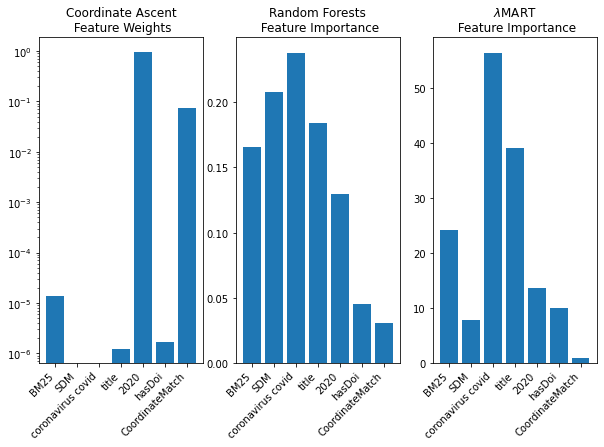

In [60]:
import numpy as np
import matplotlib.pyplot as plt

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 6))

ax0.bar(np.arange(len(fnames)), ca_pipe[1].model.to_dict()['Linear']['weights'])
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Coordinate Ascent\n Feature Weights")
ax0.set_yscale('log')

ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("$\lambda$MART\n Feature Importance")

fig.show()


### Concatenation

Our learned model has low recall because only 10 documents are re-ranked. Lets make a small function, `append_baseline()`, that can append the BM25 baselines results to the output of the learned model. This is defined using [transformer operators](https://pyterrier.readthedocs.io/en/latest/operators.html) (`^` and `%`).

As an exercise, apply `append_baseline()` to each of the learned model pipelines defined above, and report the MAP and NDCG computed on all 1000 ranked results. 

Which of the learned models result in significantly improved MAP and NDCG?


In [61]:
def append_baseline(system, baseline, max_results = 1000):
    return (system ^ baseline) % max_results

Now run an evaluation on the extended models comparing them with a base BM25

In [62]:
# TODO
pt.Experiment(
    [bm25] + [append_baseline(x, bm25) for x in [ca_pipe, rf_pipe, lmart_x_pipe]],
    test_topics,
    qrels, 
    names=["BM25",  "BM25 + CA(7f)", "BM25 + RF(7f)", "BM25 + LMart(7f)"],
    baseline=0,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt"]
)

12:38:46.578 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
12:38:50.657 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.1s finished


12:38:54.388 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,map,ndcg,ndcg_cut_10,mrt,map +,map -,map p-value,ndcg +,ndcg -,ndcg p-value,ndcg_cut_10 +,ndcg_cut_10 -,ndcg_cut_10 p-value
0,BM25,0.137704,0.330878,0.534369,50.289096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BM25 + CA(7f),0.138772,0.334735,0.571913,206.632993,6.0,5.0,0.118823,9.0,3.0,0.102075,9.0,3.0,0.115783
2,BM25 + RF(7f),0.139659,0.337038,0.594795,295.067433,9.0,2.0,0.013729,10.0,2.0,0.019839,10.0,2.0,0.015158
3,BM25 + LMart(7f),0.138440,0.333844,0.565957,224.761766,6.0,3.0,0.156135,9.0,4.0,0.050903,9.0,4.0,0.058490
